### extract the Copernicus rainfall forecasts for *land* grid points falling within the EEZ of each ICU country   


uses a land-sea mask derived from the ETOPO1 dataset, see notebook `etopo_to_landseamask.ipynb` in ~/data/etopo1

the conversion of the EEZ geometries from -180 -> 180 longitude to 0 -> 360 is done in the notebook `convert_shapefiles_0_360_EEZ.ipynb`

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
import glob
import json
import pathlib

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import cartopy.crs as ccrs
from cartopy import feature

In [6]:
import xarray as xr
import cfgrib
import pygrib

In [7]:
from datetime import datetime, timedelta

In [8]:
from monthdelta import monthdelta
from calendar import monthrange

In [9]:
import salem

In [10]:
import cdsapi

In [11]:
import geopandas as gpd
import fiona 

In [12]:
def get_dataframe_dist(dset, shape, varname='tpara', all_touched=False): 
    dset = dset.mean('step')
    dset = dset.salem.subset(shape=shape, margin=0)
    dset_map = dset.salem.roi(shape=shape, all_touched=all_touched)
    dset_index = dset_map.mean('latitude').mean('longitude')
    dset_index = dset_index.to_dataframe()
    dset_index = dset_index.loc[:,[varname]]
    #     dset_index = (dset_index - dset_index.mean()) / dset_index.std()
    dset_index = dset_index * 1e9
    return dset_index, dset_map.mean('number') * 1e9

In [13]:
def plot_region_map(dset, model='ECMWF', vmin=-5, vmax=5, step=1, ax=None, cmap=plt.cm.RdBu, central_longitude=180, varname='tpara_masked'): 
    im = ax.pcolormesh(dset.longitude - central_longitude, dset.latitude, dset[varname], vmin=vmin, vmax=vmax, cmap=cmap)
    cb = plt.colorbar(im, ax=ax, orientation='horizontal', ticks=np.arange(-5, 5 + 1, 1), boundaries=np.arange(vmin, vmax + step, step), drawedges=True, pad=0.01)
    [l.set_fontsize(10) for l in cb.ax.xaxis.get_ticklabels()]
    ax.coastlines(resolution='10m')
    ax.set_title(model)
    ax.gridlines(linestyle=':', alpha=0.5)

In [14]:
def round_to_100_percent(number_set, digit_after_decimal=2):
    """
        This function take a list of number and return a list of percentage, which represents the portion of each number in sum of all numbers
        Moreover, those percentages are adding up to 100%!!!
        Notice: the algorithm we are using here is 'Largest Remainder'
        The down-side is that the results won't be accurate, but they are never accurate anyway:)
    """
    unround_numbers = [x / float(sum(number_set)) * 100 * 10 ** digit_after_decimal for x in number_set]
    decimal_part_with_index = sorted([(index, unround_numbers[index] % 1) for index in range(len(unround_numbers))], key=lambda y: y[1], reverse=True)
    remainder = 100 * 10 ** digit_after_decimal - sum([int(x) for x in unround_numbers])
    index = 0
    while remainder > 0:
        unround_numbers[decimal_part_with_index[index][0]] += 1
        remainder -= 1
        index = (index + 1) % len(number_set)
    return [int(x) / float(10 ** digit_after_decimal) for x in unround_numbers]

### try and retrieve the seasonal forecasts from ALL centres

In [15]:
month = 3
year = 2019

In [16]:
varname = 'tpara'

In [17]:
download = False

In [18]:
forecast_dir = 'AMJ_2019'

In [19]:
dpath_copernicus = pathlib.Path.home()  / 'drives' / 'auck_projects' / 'END19101' / 'Working' / 'data' / 'forecasts'

In [20]:
centres = ['cmcc','dwd','ecmwf','meteo_france','ukmo']

In [21]:
if download:
    
    c = cdsapi.Client()
    
    for centre in centres:
        c = cdsapi.Client()
        c.retrieve(
        'seasonal-postprocessed-single-levels',
        {
            'format':'grib',
            'originating_centre':centre,
            'variable':'total_precipitation_anomalous_rate_of_accumulation',
            'product_type':'monthly_mean',
            'year':str(year),
            'month':str(month),
            'leadtime_month':[
                '2','3','4'
            ]
        },
        '{}/{}/{}_seas_forecasts_from_{}_{}_{}.grib'.format(str(dpath_copernicus), centre, varname, year, month, centre))

In [46]:
ecmwf = xr.open_dataset(dpath_copernicus / 'ecmwf' / 'ensemble_tpara_seas_forecasts_from_{}_{}_ecmwf.grib'.format(year, month), \
                        engine='cfgrib', backend_kwargs={'indexpath':''})

In [47]:
ukmo = xr.open_dataset(dpath_copernicus / 'ukmo' / 'ensemble_tpara_seas_forecasts_from_{}_{}_ukmo.grib'.format(year, month), \
                       engine='cfgrib', backend_kwargs={'indexpath':''})

In [48]:
meteo_france = xr.open_dataset(dpath_copernicus / 'meteo_france' / 'ensemble_tpara_seas_forecasts_from_{}_{}_meteo_france.grib'.format(year, month), \
                               engine='cfgrib', backend_kwargs={'indexpath':''})

In [49]:
cmcc = xr.open_dataset(dpath_copernicus / 'cmcc' / 'ensemble_tpara_seas_forecasts_from_{}_{}_cmcc.grib'.format(year, month), \
                       engine='cfgrib', backend_kwargs={'indexpath':''})

In [50]:
dwd = xr.open_dataset(dpath_copernicus / 'dwd' / 'ensemble_tpara_seas_forecasts_from_{}_{}_dwd.grib'.format(year, month), \
                      engine='cfgrib', backend_kwargs={'indexpath':''})

### interpolates the ECMWF dataset onto the others' grid

In [27]:
ecmwf = ecmwf.interp_like(ukmo)

### Now interpolates onto a 1/4 degree grid 

In [28]:
interp_res = True

In [29]:
if interp_res: 
    
    new_lon = np.arange(dwd.longitude.data[0], dwd.longitude.data[-1] + 0.25, 0.25)

    new_lat = np.arange(dwd.latitude[0], dwd.latitude[-1] - 0.25, -0.25)

    new_grid = {}
    new_grid['latitude'] = (('latitude', new_lat))
    new_grid['longitude'] = (('longitude', new_lon))

    new_grid = xr.Dataset(new_grid)

    #### now interpolate 

    ecmwf = ecmwf.interp_like(new_grid)

    cmcc = cmcc.interp_like(new_grid)

    dwd = dwd.interp_like(new_grid)

    meteo_france = meteo_france.interp_like(new_grid)

    ukmo = ukmo.interp_like(new_grid)

### reads the land sea-mask 

There are 2 options, native resolution or interpolated resolution

In [30]:
if interp_res: 
    lsmask = xr.open_dataset(pathlib.Path.cwd().parents[1] / 'data' / 'etopo1' / 'topo_0.25deg_RATIO_topo.nc')
else: 
    lsmask = xr.open_dataset(pathlib.Path.cwd().parents[1] / 'data' / 'etopo1' / 'topo_1deg_RATIO_topo.nc')

In [31]:
per = 0.0001

In [32]:
mask = lsmask.where(lsmask.topo >= per).topo

In [33]:
mask_data = mask.data

In [34]:
mask_data[mask_data >= 0] = 1

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [35]:
lsmask['mask_per'] = (('latitude', 'longitude'), mask_data)

### plots the land sea mask 

In [36]:
lsmask

<xarray.Dataset>
Dimensions:    (latitude: 717, longitude: 1437)
Coordinates:
  * latitude   (latitude) float64 89.5 89.25 89.0 88.75 ... -89.0 -89.25 -89.5
  * longitude  (longitude) float64 0.5 0.75 1.0 1.25 ... 358.8 359.0 359.2 359.5
Data variables:
    topo       (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask       (latitude, longitude) float64 ...
    topo_land  (latitude, longitude) float64 ...
    mask_per   (latitude, longitude) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

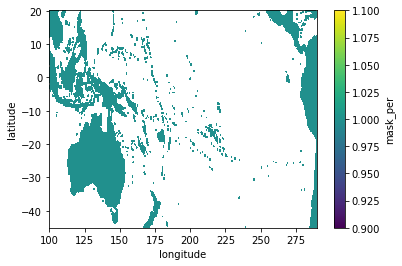

In [37]:
lsmask.sel(longitude=slice(100, 290), latitude=slice(20, -45))['mask_per'].plot()

#### multiply the forecasts by the land sea mask 

In [37]:
cmcc['tpara_masked'] = cmcc['tpara'] * lsmask['mask_per']

In [38]:
dwd['tpara_masked'] = dwd['tpara'] * lsmask['mask_per']

In [39]:
ecmwf['tpara_masked'] = ecmwf['tpara'] * lsmask['mask_per']

In [40]:
meteo_france['tpara_masked'] = meteo_france['tpara'] * lsmask['mask_per']

In [41]:
ukmo['tpara_masked'] = ukmo['tpara'] * lsmask['mask_per']

### loads the JSON file containing the dictionnary mapping the filenames for the converted shapefiles for each country to the actual country names with special characters

In [42]:
with open(pathlib.Path.cwd().parents[1] / 'resources' /  'country_names_dictionnary.json', 'r') as fp: 
    dict_country_names = json.load(fp)

### path to the shapefiles for the ICU Island Groups 

In [43]:
shapes_from_geojson_path = pathlib.Path.cwd().parents[1] /  'data' / 'shapefiles' / 'geojson' / 'converted'

### make the forecast path if it doesnt exist 

In [44]:
if not (pathlib.Path.cwd().parent / 'figures' / 'forecasts' / forecast_dir).exists(): 
    (pathlib.Path.cwd().parent / 'figures' / 'forecasts' / forecast_dir).mkdir(parents=True)

### loops over the country names, and derive the probabilistic forecasts from the distribution of rainfall anomalies 

In [45]:
dist_probs = []
all_probs = []

for country_fname in dict_country_names.keys(): 
    
    country_name = dict_country_names[country_fname]
    
    print("processing {}".format(country_name))
    
    shape = gpd.read_file(shapes_from_geojson_path / 'shapes_{}_converted.shp'.format(country_fname))
    
    ecmwf_index, ecmwf_map = get_dataframe_dist(ecmwf, shape, varname='tpara_masked', all_touched=True) 
    meteo_france_index, meteo_france_map = get_dataframe_dist(meteo_france, shape, varname='tpara_masked', all_touched=True)
    ukmo_index, ukmo_map = get_dataframe_dist(ukmo, shape, varname='tpara_masked', all_touched=True)
    dwd_index, dwd_map = get_dataframe_dist(dwd, shape, varname='tpara_masked', all_touched=True) 
    cmcc_index, cmcc_map = get_dataframe_dist(cmcc, shape, varname='tpara_masked', all_touched=True)
    
    concat_dist = pd.concat([ecmwf_index, ukmo_index, meteo_france_index, cmcc_index, dwd_index], axis=0)
    
    concat_dist = concat_dist.dropna()
    
    concat_dist.to_csv(pathlib.Path.cwd().parent / 'outputs' / 'distribution_{}_v2_{}.csv'.format(country_fname, forecast_dir))
    
    sns.set_context('paper')
    
    concat_dist_3cat = concat_dist.copy()
    
    labels = ['T1','T2','T3'] 
    
    # starts with a U-shaped tercile distribution, then iteratively change 
    # the threshold until the distribution is ordered
    
    dist_prob3 = pd.Series([40,20,40], index=labels)
    
    boundary = 4
    
    while (dist_prob3.T3 > dist_prob3.T2) and (dist_prob3.T1 > dist_prob3.T2): 

        thresholds = [-np.inf, -boundary, boundary + 1e-9, np.inf]

        concat_dist_3cat.loc[:,'outcome'] = pd.cut(concat_dist_3cat.tpara_masked.values.flatten(), thresholds, labels=labels)

        dist_prob3 = ((pd.value_counts(concat_dist_3cat.outcome) / len(concat_dist_3cat)) * 100).reindex(labels)

        dist_prob3.loc[:,] = np.array(round_to_100_percent(dist_prob3.values, digit_after_decimal=0))

        boundary += 1

    mat_prob = dist_prob3.to_frame().T
    mat_prob.index = [country_fname]
    mat_prob.loc[:,'country_fname'] = country_fname
    mat_prob.loc[:,'country_name'] = country_name
    all_probs.append(mat_prob)
    
    label = "Blw: {0}, Nml: {1}, Abv: {2}".format(*dist_prob3.values.tolist())

    f, ax = plt.subplots()
    f.subplots_adjust(bottom=0.26, top=0.85, left=0.15)
    dist_prob3.plot(kind='bar', color=['coral','0.8','steelblue'], ax=ax, width=0.9)
    ax.set_title("{}: {}\n{}, threshold {} mm".format(country_name, varname, label, boundary))
    ax.set_ylabel('%')
    f.savefig(pathlib.Path.cwd().parent / 'figures' / 'forecasts' / forecast_dir / '{}_3cat_{}.png'.format(country_fname, forecast_dir), dpi=200)   
    plt.close(f)
    
    f, ax = plt.subplots()
    f.subplots_adjust(top=0.75)
    sns.distplot(concat_dist, ax=ax, rug=True, norm_hist=True, color='0.3')
    ax.axvline(0, color='k')
    ax.axvline(-boundary, color='b', lw=2)
    ax.axvline(boundary, color='r', lw=2)
    ax.grid(ls=':')
    ax.set_title('distribution of rainfall anomalies\n{}\nN = {}'.format(country_name, len(concat_dist.dropna())))
    f.savefig(pathlib.Path.cwd().parent / 'figures' / 'forecasts' / forecast_dir / 'distribution_{}_v2_{}.png'.format(country_fname, forecast_dir), dpi=200)
    plt.close(f)
    
    concat_dist.columns = [country_name]
    
    dist_probs.append(concat_dist)
    

processing New Caledonia


/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


processing Pitcairn Islands
processing Papua New Guinea
processing Solomon Islands
processing Kiribati: Phoenix Islands
processing Fiji
processing Tuvalu
processing Northern Cook Islands
processing Kiribati: Line Islands
processing Federated States of Micronesia
processing Samoa
processing Kiribati: Gilbert Islands
processing Wallis & Futuna
processing Tokelau
processing Tuamotu / Gambier Islands
processing Tonga
processing Niue
processing Southern Cook Islands
processing Austral Islands
processing Society Islands
processing Marquesas
processing Vanuatu South
processing Vanuatu North
processing Guam
processing Northern Marianas
processing Marshall Islands
processing Nauru
processing Palau
processing American Samoa


### concatenates the forecasts in one Pandas DataFrame 

In [51]:
all_probs_df = pd.concat(all_probs, axis=0)

In [52]:
all_probs_df = all_probs_df.astype({"T1": int, "T2": int, 'T3':int})

In [53]:
all_probs_df.head()

,T1,T2,T3,country_fname,country_name
New_Caledonia,72,17,11,New_Caledonia,New Caledonia
Pitcairn_Islands,26,27,47,Pitcairn_Islands,Pitcairn Islands
Papua_New_Guinea,43,31,26,Papua_New_Guinea,Papua New Guinea
Solomon_Islands,26,32,42,Solomon_Islands,Solomon Islands
Kiribati:_Phoenix_Islands,1,2,97,Kiribati:_Phoenix_Islands,Kiribati: Phoenix Islands


In [54]:
dist_probs_all = pd.concat(dist_probs, axis=1)

In [55]:
std_dist = dist_probs_all.std().to_frame()

In [56]:
std_dist.columns = ['std']

In [57]:
all_probs_df = all_probs_df.set_index('country_name')

In [58]:
all_probs_df = all_probs_df.merge(std_dist, left_index=True, right_index=True)

### calculates the confidence level from the standard deviation of the rainfall anomalies (subjective)

In [59]:
all_probs_df.loc[:,'CONFIDENCE'] = pd.cut(all_probs_df.loc[:,'std'], bins=[0, 15, 20, 25], labels=['High','Moderate-High','Moderate'])

In [60]:
all_probs_df.index.name = 'country_name'

### if the bulletin directory does not exists, create it 

In [61]:
opath = pathlib.Path.cwd().parents[1] / 'bulletin' / forecast_dir

In [62]:
if not opath.exists(): 
    opath.mkdir(parents=True)

### saves the forecasts to disk 

In [63]:
all_probs_df.to_csv(opath / 'copernicus_forecasts_{}.csv'.format(forecast_dir))